In [188]:
# Notebook for modelling breakthrough PReCaP
import numpy as np
import matplotlib.pyplot as plt


In [209]:
timesteps = 10
np.random.seed(1)

scc_ests = np.zeros(timesteps)  # scc estimates
scc_stds = np.zeros(timesteps)  # scc standard errors

p_avoids = np.zeros(timesteps)  # prices of avoidance credits
p_reduces = np.zeros(timesteps)  # prices of reduction credits
total_costs = np.zeros(timesteps)  # total costs paid for credits
avoid_costs = np.zeros(timesteps) # total costs paid for easy to abate credits
reduce_costs = np.zeros(timesteps) # total costs paid for hard to abate credits
c_avoids = np.zeros(timesteps)  # purchased avoidance credits
c_reduces = np.zeros(timesteps)  # purchased reduction credits

em_limits = np.linspace(1,0,timesteps)  # carbon emissions limits
emissions = np.linspace(100, 200, num=timesteps)  # initial emissions

em_easy = 0.7  # easy to abate proportion of emissions
discount_rate = 0.985  # discount rate, yearly
true_scc = 1000  # True scc in BAU scenario
scc_est_0 = 150  # initial scc estimate
scc_std_0 = 50  # initial scc standard error
p_avoid_0 = 100  # initial price of avoidance credits
p_reduce_0 = 300  # initial price of reduction credits


In [210]:
em_limits

array([1.        , 0.88888889, 0.77777778, 0.66666667, 0.55555556,
       0.44444444, 0.33333333, 0.22222222, 0.11111111, 0.        ])

In [211]:
def _easy_emissions(emissions=emissions, em_easy=em_easy):
    """
    Calculate emissions that are easy to abate
    Inputs:
        - emissions, timeseries of emissions
        - em_easy, proportion of easy to abate emissions
    Outputs:
        - easy_emissions, timeseries of easy to abate emissions
    """
    return emissions * em_easy  # placeholder


def _hard_emissions(emissions=emissions, em_easy=em_easy):
    """
    Calculate emissions that are easy to abate
    Inputs:
        - emissions, timeseries of emissions
        - em_easy, proportion of easy to abate emissions
    Outputs:
        - easy_emissions, timeseries of hard to abate emissions
    """
    return emissions * (1 - em_easy)  # placeholder


In [212]:
def update_scc_est(true_scc, scc_est, scc_std):
    """
    Update the scc estimate
    """

    return scc_est_0 + np.random.randn() * scc_std  # placeholder


def update_p_avoid(p_avoid, c_avoid):
    """
    Calculate the new price of avoidance credits based on purchased credits.
    Based on experience curves
    Inputs:
        - p_avoid, current price of avoidance credits
        - c_avoid, current purchased carbon credits
    Outputs:
        - p_avoid_new, updated price of avoidance credits
    """
    return (1 / (1 + np.log(1 + c_avoid))) * p_avoid  # placeholder


def update_p_reduce(p_reduce, c_reduce):
    """
    Calculate the new price of reduction credits based on purchased credits.
    Based on experience curves
    Inputs:
        - p_avoid, current price of reduction credits
        - c_avoid, current purchased carbon credits
    Outputs:
        - p_avoid_new, updated price of reduction credits
    """
    return (1 / (1 + np.log(1 + c_reduce))) * p_reduce  # placeholder


In [213]:
def purchase_credits(
    em_limit,
    easy_emissions,
    hard_emissions,
    p_avoid,
    p_reduce,
    discount_rate,
    solver=None,
):
    """
    Wrapper for deciding the purchase of credits at a given timestep.
    Assumption: agent is myopic and optimizes only the current timestep.
    Currently, does not use the discount rate for optimization.
    Inputs: ...
    Outputs: ...
    """

    required_abatement = (1 - em_limit) * (easy_emissions + hard_emissions)

    if solver == None:
        c_avoid = min(
            easy_emissions, required_abatement
        )  # buy max of avoid credits
        c_reduce = required_abatement - c_avoid  # rest is reduce credits

    else:
        c_avoid, c_reduce = solver(
            required_abatement,
            easy_emissions,
            hard_emissions,
            p_avoid,
            p_reduce,
            discount_rate,
        )

    avoid_cost = c_avoid * p_avoid
    reduce_cost = c_reduce * p_reduce
    total_cost = c_avoid * p_avoid + c_reduce * p_reduce

    return c_avoid, c_reduce, avoid_cost, reduce_cost


In [214]:
scc_est = scc_est_0
scc_std = scc_std_0
p_avoid = p_avoid_0
p_reduce = p_reduce_0

for step, em_limit in enumerate(em_limits):
    emission = emissions[step]
    easy_emissions = _easy_emissions(emission, em_easy)
    hard_emissions = _hard_emissions(emission, em_easy)

    c_avoid, c_reduce, avoid_cost, reduce_cost = purchase_credits(
        em_limit=em_limit,
        easy_emissions=easy_emissions,
        hard_emissions=hard_emissions,
        p_avoid=p_avoid,
        p_reduce=p_reduce,
        discount_rate=discount_rate,
        solver=None,
    )

    # log variables
    scc_ests[step] = scc_est
    scc_stds[step] = scc_std

    p_avoids[step] = p_avoid
    p_reduces[step] = p_reduce

    c_avoids[step] = c_avoid
    c_reduces[step] = c_reduce

    avoid_costs[step] = (
        avoid_costs[step - 1] + avoid_cost if step >= 1 else avoid_cost
    )
    reduce_costs[step] = (
        reduce_costs[step - 1] + reduce_cost if step >= 1 else reduce_cost
    )
    
    total_cost = avoid_cost + reduce_cost
    total_costs[step] = (
        total_costs[step - 1] + total_cost if step >= 1 else total_cost
    )

    # update variables
    scc_est = update_scc_est(true_scc, scc_est, scc_std)
    p_avoid = update_p_avoid(p_avoid, c_avoid)
    p_reduce = update_p_reduce(p_reduce, c_reduce)


Text(0, 0.5, 'dollars')

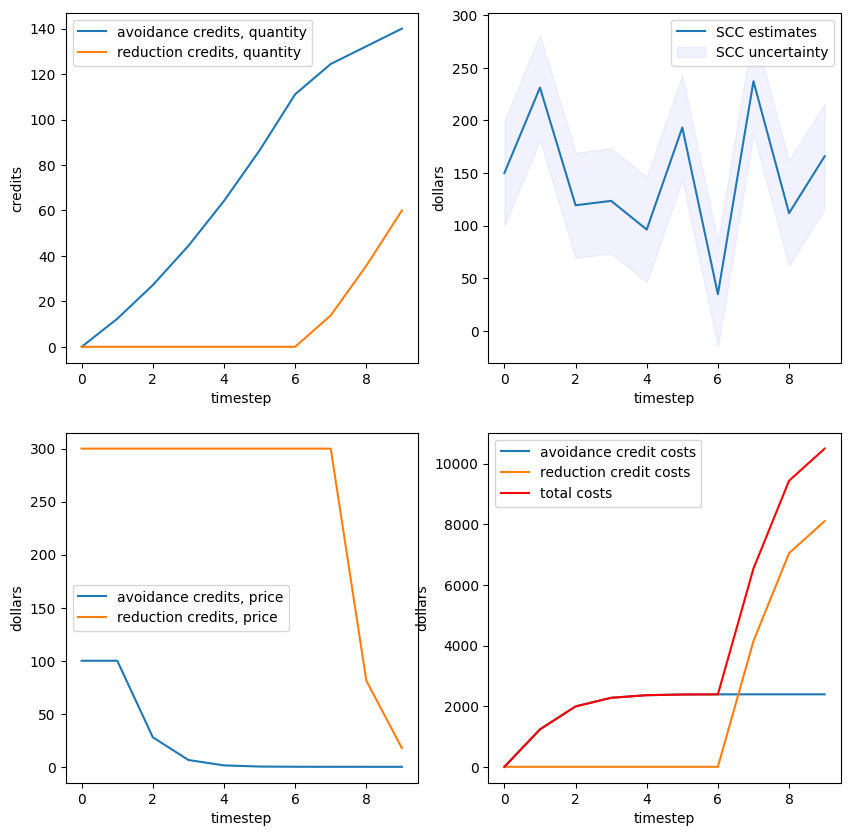

In [215]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))


axes[0, 0].plot(c_avoids, label="avoidance credits, quantity")
axes[0, 0].plot(c_reduces, label="reduction credits, quantity")
axes[0, 0].legend()
axes[0, 0].set_xlabel('timestep')
axes[0, 0].set_ylabel('credits')

axes[1, 0].plot(p_avoids, label="avoidance credits, price")
axes[1, 0].plot(p_reduces, label="reduction credits, price")
axes[1, 0].legend()
axes[1, 0].set_xlabel('timestep')
axes[1, 0].set_ylabel('dollars')


axes[0, 1].plot(scc_ests, label="SCC estimates")
axes[0, 1].fill_between(
    range(timesteps),
    scc_ests + scc_stds,
    scc_ests - scc_stds,
    color="blue",
    alpha=0.05,
    label="SCC uncertainty",
)
axes[0, 1].legend()
axes[0, 1].set_xlabel('timestep')
axes[0, 1].set_ylabel('dollars')


axes[1, 1].plot(avoid_costs, label="avoidance credit costs")
axes[1, 1].plot(reduce_costs, label="reduction credit costs")
axes[1, 1].plot(total_costs, label="total costs", color='red')
axes[1, 1].legend()
axes[1, 1].set_xlabel('timestep')
axes[1, 1].set_ylabel('dollars')
